python3 -m openpivgui.OpenPivGui to use the GUI

In [ ]:
#Standar libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import imageio
import os
# import openpiv as piv
# import openpiv.pyprocess
from openpiv import tools, pyprocess, validation, filters, scaling
from PIL import Image

#Function to compute the PIV
def computePIV(frame_a,frame_b,window_sizePIV=48,search_area_sizePIV=64,overlapPIV=24,dtPIV=1):

    
    frame_a=np.array(frame_a,dtype=np.int32)#frame_a.astype(np.int32)
    frame_b=np.array(frame_b,dtype=np.int32)#frame_b.astype(np.int32)

    u, v, sig2noise = pyprocess.extended_search_area_piv( \
            frame_a, frame_b, \
            window_size=window_sizePIV, \
            overlap=overlapPIV, \
            dt=dtPIV, \
            search_area_size=search_area_sizePIV, \
            sig2noise_method='peak2peak' )

    x, y = pyprocess.get_coordinates( \
            image_size=frame_a.shape, \
            search_area_size=search_area_sizePIV, 
            overlap=overlapPIV )
    
    
    
    return x,y,u,v,sig2noise

# If you need to split a movie into frames

In [ ]:
input_file='/Users/jeromenoir/polybox2/ENSEIGNEMENTS/INTRO_FLUID_DYNAMICS/EXAM/Exams_2024/Report1_BUCKET/movie1_r35.MOV'
output_dir='/Users/jeromenoir/polybox2/ENSEIGNEMENTS/INTRO_FLUID_DYNAMICS/EXAM/Exams_2024/Report1_BUCKET/movie1_r35frames'

video = cv2.VideoCapture(input_file)
ok, frame = video.read()
count = 0
while ok:
    cv2.imwrite(output_dir + "_frame%i.jpg"%count, frame)
    print('WRITTEN FRAME:',count)
    count+=1
    ok, frame = video.read()
video.release()



# Set the directories

In [7]:
#List of images to proccess
dirImages = "./Example/Images/"
dirResults = "./Example/Results/"
extension = "png"


# =========================================================================
# SETING UP FOLDERS
# Check if the input folder is empty
# =========================================================================
if not os.path.exists(dirImages):
    print(f"Error: Input folder '{dirImages}' does not exist.")
    exit(1)
if not os.path.exists(dirResults):
    os.makedirs(dirResults)


# =========================================================================
# LIST OF IMAGES TO PROCESS
# =========================================================================
files = sorted([f for f in os.listdir(dirImages) if f.endswith(extension)])
if len(files) < 2:
    print("Error: Not enough images to process. At least two images are required.")
    exit(1)
print(f"Found {len(files)} images to process: {files}")

Found 2 images to process: ['U_Mixing_1002_1.png', 'U_Mixing_1002_2.png']


## to visualize 2 images

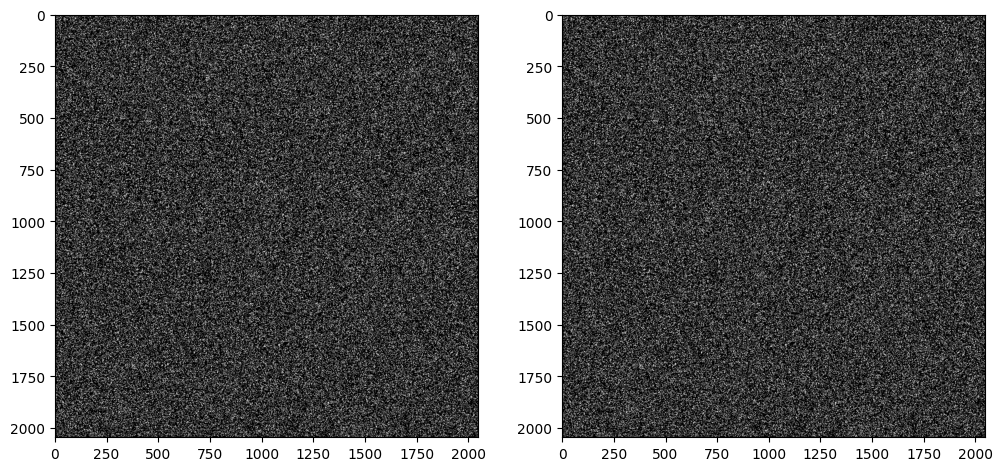

In [3]:
frame_a  = tools.imread( dirImages+files[0] )
frame_b  = tools.imread( dirImages+files[1] )
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

# Perform PIV calculation on 2 images, filter, rescale, transform coordinates, save and plot.

In [4]:
imageFile1=dirImages+files[0]
imageFile2=dirImages+files[1]
image1=Image.open(imageFile1).convert('L')
image2=Image.open(imageFile2).convert('L')

window_sizePIV=16
search_area_sizePIV=32
overlapPIV=8 #(needs to be smaller than the window size)
dtPIV=1

#Compute PIV
x,y,u,v,sig2noise=computePIV(image1,image2,window_sizePIV,\
 search_area_sizePIV,overlapPIV,dtPIV)

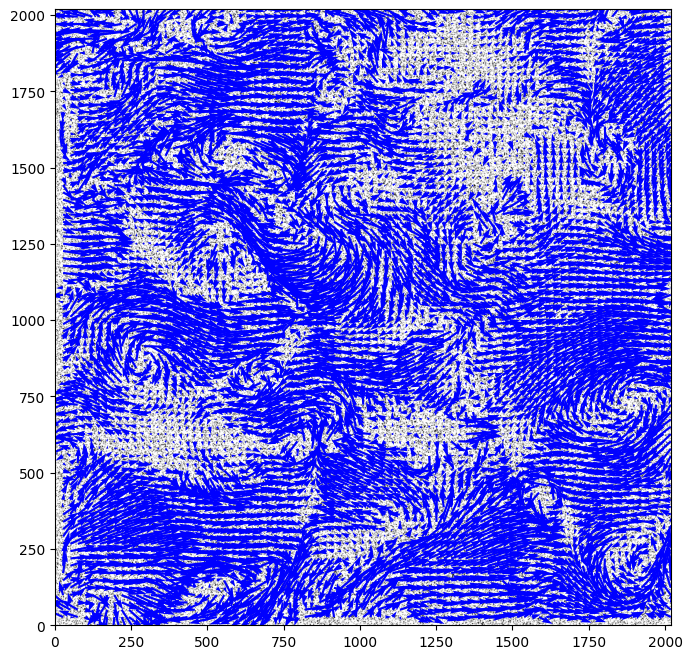

In [5]:
#filter outliers
invalid_mask = validation.sig2noise_val(
                sig2noise,
                threshold = 1.2
                )#local_median_val( u, v,7,7,size=1 )
    #u, v = openpiv.filters.replace_outliers( u, v, method='localmean', max_iter=5,kernel_size=2)
u2, v2 =filters.replace_outliers(u, v,invalid_mask,method='localmean',max_iter=3,kernel_size=5)




#optional scaling:

# convert x,y to mm
# convert u,v to mm/sec
# x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
#                                scaling_factor = 96.52 ) # 96.52 microns/pixel


#optional rotation of the coordinate system:

# 0,0 shall be bottom left, positive rotation rate is counterclockwise
x3, y3, u3, v3 = tools.transform_coordinates(x, y, u2, v2)

#save in the simple ASCII table format
tools.save(dirResults+'exp1_001.txt', x3, y3, u3, v3)


#plot the re
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field(dirResults+'exp1_001.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=50, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=True, # overlay on the image
                           image_name=dirImages+files[0]);